# Plots for the 2MDM analysis

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os,shutil
from pandas import json_normalize

import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from collections import OrderedDict
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
from IPython.display import display, Markdown

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_98174/1200496628.py:5: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import glob,imp,os,shutil
/var/folders/b3/l10x2d9503j4vrszk86wqw040000gn/T/ipykernel_98174/1200496628.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


#### Create txname/process translator

In [2]:
processDict = {'TRV1tt' : r'$p p \to \bar{t} t$',
               'TRV1jj' : r'$p p \to j j$',
               'TRV1bb' : r'$p p \to \bar{b} b$',
               'TRV1qq' : r'$p p \to \bar{q} q$',
               'TRV1' : r'$p p \to \chi \chi$',
               'TRS1' : r'$p p \to \chi \chi$'}
def convertLabel(label):
    newlabel = label[:]
    #Replace txnames by process
    for txlabel,proc in processDict.items():
        newlabel = newlabel.replace(txlabel,proc) 
    return newlabel

#### Get data in pcl format and print all columns names

In [3]:
#Merge with SModelS DataFrame
pclFiles = ['./smodels_results_slha_gchi_001.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mass.9000006', 'mass.9900032', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'mass.9900026', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'extpar.1', 'extpar.2', 'extpar.3', 'extpar.4', 'extpar.5', 'extpar.6', 'extpar.7', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.sd.chi,chi', 'BRs.zp.b,b', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.t-,t+', 'BRs.sd.ta+,ta-', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'OutputStatus.sigmacut', 'OutputStatus.minmassgap', 'OutputStatus.maxcond', 'OutputStatus.ncpus', 'OutputStatus.model', 'OutputStatus.promptwidth', 'Ou

#### Set r = 0 for points with no results 

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [5]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [6]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 35990
Total excluded (LHC) = 13966
Total allowed = 22024



### Get all analyses in one column

In [7]:
idCols = [c for c in dataDF.columns if 'AnalysisID' in c]
txCols = [c for c in dataDF.columns if 'TxNames' in c]
print(idCols)

['ExptRes.result0.AnalysisID', 'ExptRes.result1.AnalysisID', 'ExptRes.result2.AnalysisID', 'ExptRes.result3.AnalysisID', 'ExptRes.result4.AnalysisID', 'ExptRes.result5.AnalysisID']


In [8]:
ana, tx = [], []
for c in idCols:
    for i in dataDF[c].dropna().unique():
        ana.append(i)
        
for c in txCols:
    for txlist in dataDF[c].dropna():
        for i in txlist:
            tx.append(i)

In [9]:
txnames = pd.Series(tx).drop_duplicates().tolist()
analysis = pd.Series(ana).drop_duplicates().tolist()

In [10]:
txnames.append(['TRS1', 'TRV1'])

In [11]:
txnames

['TRV1jj', 'TRV1qq', 'TRV1bb', 'TRV1tt', 'TRS1', 'TRV1', ['TRS1', 'TRV1']]

In [12]:
filteredDF = []
# anaID = analysis
# txID = txnames
for irow,row in dataDF.iterrows():
    for anaID in analysis:
        for txID in txnames:
            resCols = [idc for idc in idCols if (row[idc] == anaID and (row[idc.replace('AnalysisID','TxNames')] == [txID]
                                                                       or row[idc.replace('AnalysisID','TxNames')] == ['TRS1', 'TRV1']))]
            if not resCols:
                continue
            resCol = resCols[0].rsplit('.',1)[0]
            newrow = {c.replace(resCol,'ExptRes.result') : row[c] for c in dataDF.columns if (('ExptRes' not in c) or (resCol in c))}
            filteredDF.append(newrow)  

In [13]:
newDF = pd.DataFrame.from_dict(filteredDF)

In [14]:
newDF[['ExptRes.result.AnalysisID','ExptRes.result.TxNames','ExptRes.result.r']]

,ExptRes.result.AnalysisID,ExptRes.result.TxNames,ExptRes.result.r
0,ATLAS-EXOT-2019-03,[TRV1jj],7.364795
1,ATLAS-EXOT-2013-11,[TRV1qq],0.530455
2,CMS-EXO-12-059,[TRV1qq],0.357318
3,CMS-EXO-20-004,[TRV1],0.000003
4,ATLAS-EXOT-2019-03,[TRV1jj],7.361164
...,...,...,...
178597,CMS-EXO-20-004,[TRV1],-1.000000
178598,CMS-EXO-20-004,[TRV1],-1.000000
178599,CMS-EXO-20-004,[TRV1],-1.000000
178600,CMS-EXO-20-004,[TRV1],-1.000000


In [15]:
newDF['excluded'] = newDF['ExptRes.result.r'] > 1.0
excluded = newDF[newDF['excluded'] == True]
anas = excluded['ExptRes.result.AnalysisID'].value_counts()
anas.sort_values(inplace=True,ascending=False)

    
labels = []
for index, row in excluded.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
excluded['label'] = labels

labels = []
for index, row in newDF.iterrows():
    ana = row['ExptRes.result.AnalysisID']
    txList = sorted(row['ExptRes.result.TxNames'])
    label = ana + ' (' + ','.join(txList) + ')'
    labels.append(label)
newDF['label'] = labels

In [16]:
newDF = newDF.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')
excluded = excluded.replace(to_replace='CMS-EXO-20-004 (TRS1,TRV1)', value='CMS-EXO-20-004 (TRV1)')

In [17]:
excluded['label'].unique()

array(['ATLAS-EXOT-2019-03 (TRV1jj)', 'ATLAS-EXOT-2018-48 (TRV1tt)',
       'CMS-EXO-19-012 (TRV1jj)', 'CMS-EXO-20-008 (TRV1bb)',
       'CMS-EXO-12-059 (TRV1qq)', 'ATLAS-EXOT-2013-11 (TRV1qq)',
       'CMS-EXO-16-057 (TRV1bb)'], dtype=object)

#### Create legend for plots for excluded points

In [18]:
colors = sns.color_palette("Set1",len(excluded['label'].unique()))


In [19]:
colorDict = {}

for i, l in enumerate(excluded['label'].unique()):
    colorDict[l] = np.array(colors[i]).reshape(-1,3)

In [20]:
legend = []
for ana, color in colorDict.items():
    l = mpatches.Patch(color=color, label=convertLabel(ana))
    legend.append(l)

### Plot only excluded points for a selected $g_{q}, g_{\chi}$ pair

In [21]:
newDF['extpar.2'].unique()

array([0.14 , 0.13 , 0.125, 0.12 , 0.25 , 0.2  , 0.1  , 0.15 , 0.145])

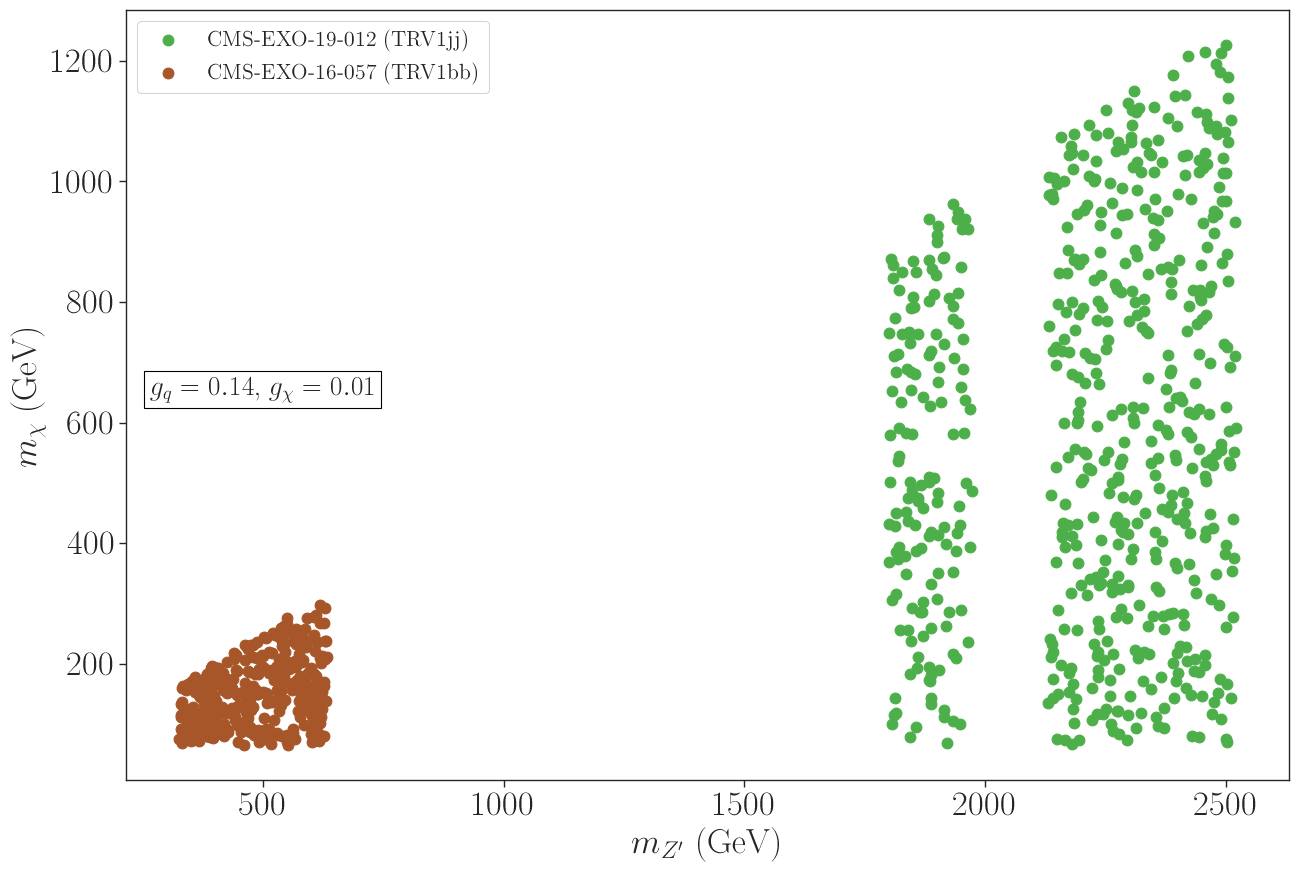

In [25]:
#cm = plt.cm.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(15,10))

gqv = 0.145
gchi = 0.01


for label in excluded['label'].unique():
#     if 'ATLAS-EXOT-2019-03' in label: continue
#     data = newDF.sort_values('ExptRes.result.r_expected').drop_duplicates(["filename"],keep='last')
    data = newDF.sort_values('ExptRes.result.r').drop_duplicates(['filename'], keep='last')
    data = data[(data['extpar.1']==gchi)&(data['extpar.2']==gqv)&(data['ExptRes.result.r']>=1.0)]
    data = data[data['label']==label]
    
    x = data['mass.9900032'].dropna()
    y = data['mass.9000006'].dropna()
    c = data['ExptRes.result.r'].dropna()
    if len(data) == 0: continue
    sc = plt.scatter(x,y,s=60, color=colorDict[label], label=label)
    

# cb = plt.colorbar(sc)
# cb.ax.tick_params(labelsize=25)
# cb.set_label(label=r'$r$',size=25)

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.5,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.legend()
# plt.savefig('./figures/exclusions_2mdm_gq01.png')
plt.show()


In [79]:
newDF[(newDF['extpar.2']==0.14)&(newDF['extpar.1']==0.01)&(newDF['mass.9900032']>1400)&(newDF['mass.9900032']<1600)
      &(newDF['ExptRes.result.r']<1)&(newDF['label']=='CMS-EXO-12-059 (TRV1qq)')]

,filename,mass.9000006,mass.9900032,mass.9000002,mass.9000003,mass.9000004,mass.9000005,mass.9900026,width.9000002,width.9000003,...,ExptRes.result.dataType,ExptRes.result.r,ExptRes.result.r_expected,ExptRes.result.Width (GeV),ExptRes.result.likelihood,ExptRes.result.l_max,ExptRes.result.l_SM,excludedLHC,excluded,label
2121,scan_nie_6xjo.slha,550.8396,1598.526,91.1876,79.82436,79.82436,1500.0,799.2632,2.4952,2.085,...,upperLimit,0.716906,0.510638,"[(zp, 14.958)]",NaN,NaN,NaN,True,False,CMS-EXO-12-059 (TRV1qq)
2125,scan_4hsww5e8.slha,641.3792,1598.209,91.1876,79.82436,79.82436,1500.0,799.1044,2.4952,2.085,...,upperLimit,0.718254,0.510925,"[(zp, 14.955)]",NaN,NaN,NaN,True,False,CMS-EXO-12-059 (TRV1qq)
2129,scan_7lf9nozi.slha,443.7055,1598.221,91.1876,79.82436,79.82436,1500.0,799.1107,2.4952,2.085,...,upperLimit,0.718163,0.510860,"[(zp, 14.956)]",NaN,NaN,NaN,True,False,CMS-EXO-12-059 (TRV1qq)
2133,scan_1jn5svqn.slha,540.3158,1597.858,91.1876,79.82436,79.82436,1500.0,798.9292,2.4952,2.085,...,upperLimit,0.719621,0.511224,"[(zp, 14.952)]",NaN,NaN,NaN,True,False,CMS-EXO-12-059 (TRV1qq)
2137,scan_p7ol77dg.slha,242.1174,1598.043,91.1876,79.82436,79.82436,1500.0,799.0217,2.4952,2.085,...,upperLimit,0.718890,0.510932,"[(zp, 14.955)]",NaN,NaN,NaN,True,False,CMS-EXO-12-059 (TRV1qq)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2847,scan_88fwx1t9.slha,165.6689,1546.447,91.1876,79.82436,79.82436,1500.0,773.2236,2.4952,2.085,...,upperLimit,0.970484,0.551574,"[(zp, 14.472)]",NaN,NaN,NaN,True,False,CMS-EXO-12-059 (TRV1qq)
2857,scan_c9j8u28h.slha,117.8599,1544.987,91.1876,79.82436,79.82436,1500.0,772.4933,2.4952,2.085,...,upperLimit,0.979084,0.553118,"[(zp, 14.458)]",NaN,NaN,NaN,True,False,CMS-EXO-12-059 (TRV1qq)
2867,scan_8t3ypwb1.slha,596.2344,1544.930,91.1876,79.82436,79.82436,1500.0,772.4650,2.4952,2.085,...,upperLimit,0.979627,0.553188,"[(zp, 14.456)]",NaN,NaN,NaN,True,False,CMS-EXO-12-059 (TRV1qq)
2871,scan_y47dqpjh.slha,505.6226,1545.141,91.1876,79.82436,79.82436,1500.0,772.5705,2.4952,2.085,...,upperLimit,0.978351,0.552938,"[(zp, 14.459)]",NaN,NaN,NaN,True,False,CMS-EXO-12-059 (TRV1qq)


### Plot exclusion regions for monojet and dijet only

In [26]:
colors = {'monojet': 'cyan', 'dijet': 'magenta'}

In [27]:
legend = []
for label, color in colors.items():
    l = mpatches.Patch(color=color, label=label)
    legend.append(l)

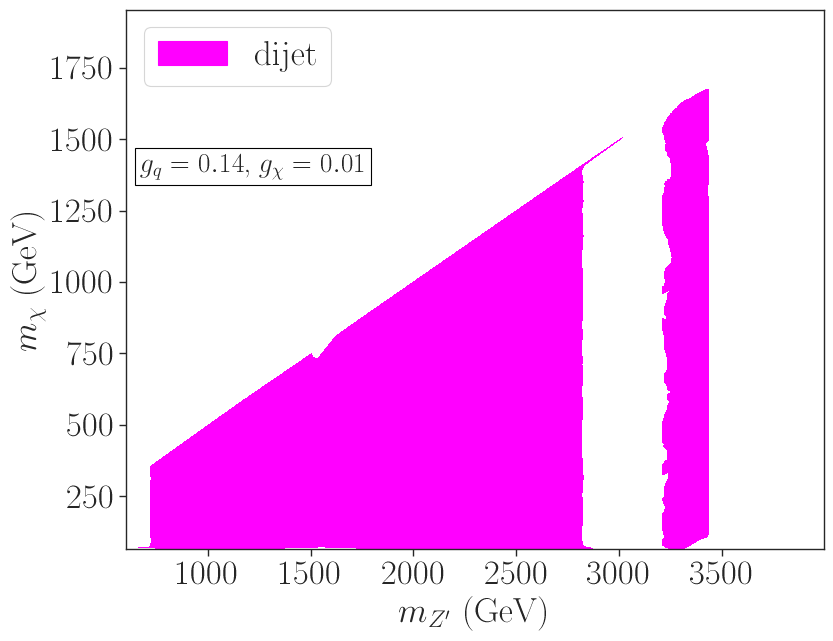

In [58]:
#cm = plt.cm.get_cmap('RdYlBu_r')
plt.colormaps['RdYlBu_r']
plt.figure(figsize=(9,7))

gqv = 0.14
gchi = 0.01

# x = dataDF['mass.9900032'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.3']==gqv)].dropna()
# y = dataDF['mass.9000006'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.3']==gqv)].dropna()
# c = dataDF['ExptRes.result0.r'][(dataDF['extpar.1']==gchi)&(dataDF['extpar.3']==gqv)].dropna()

# sc = plt.scatter(x,y,c=c,s=40,cmap=cm, vmin=0.8,vmax=1.2)

for label in excluded['label'].unique():
    if 'CMS-EXO-16-057' in label: continue
#     if 'ATLAS-EXOT-2018-48' in label: continue
#     if 'CMS-EXO-20-008' in label: continue
#     if 'ATLAS-EXOT-2013-11' in label: continue
#     if 'ATLAS-EXOT-2019-03' in label: continue
#     if 'CMS-EXO-12-059' in label: continue
#     print(label)
    data = newDF[(newDF['extpar.1']==gchi)&(newDF['extpar.2']==gqv) & (newDF['label']==label)]
    rData = data['ExptRes.result.r']
    if len(rData) == 0: continue
    pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
#     if rData.max() > 1:
#         print(len(rData))
#         print(rData.max())
    if 'CMS-EXO-20-004' in label:
        plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=1.0, colors='cyan')
    else:
        plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=1.0, colors='magenta')
    
    
plt.legend(handles=[legend[1]], fontsize=25, loc='upper left')

# cb = plt.colorbar(sc)
# cb.ax.tick_params(labelsize=25)
# cb.set_label(label=r'$r$',size=25)

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.7,r'$g_{q} = %1.2f$, $g_{\chi} = %1.2f$' % (gqv, gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
# plt.savefig('exclusions_2mdm_all.png')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.show()

In [32]:
dijetAnas = ['ATLAS-EXOT-2019-03', 'CMS-EXO-19-012', 'ATLAS-EXOT-2013-11',
           'CMS-EXO-12-059']
monojetAnas = ['CMS-EXO-20-004']

In [34]:
monojetData = dataDF[dataDF['ExptRes.result0.AnalysisID'].isin(dijetAnas)]

In [81]:
gqcolors = {0.1:'violet', 0.14:'darkviolet', 0.25:'darkmagenta'}

In [82]:
gqLegend = []
for label, color in gqcolors.items():
    l = mpatches.Patch(color=color, label=label)
    gqLegend.append(l)

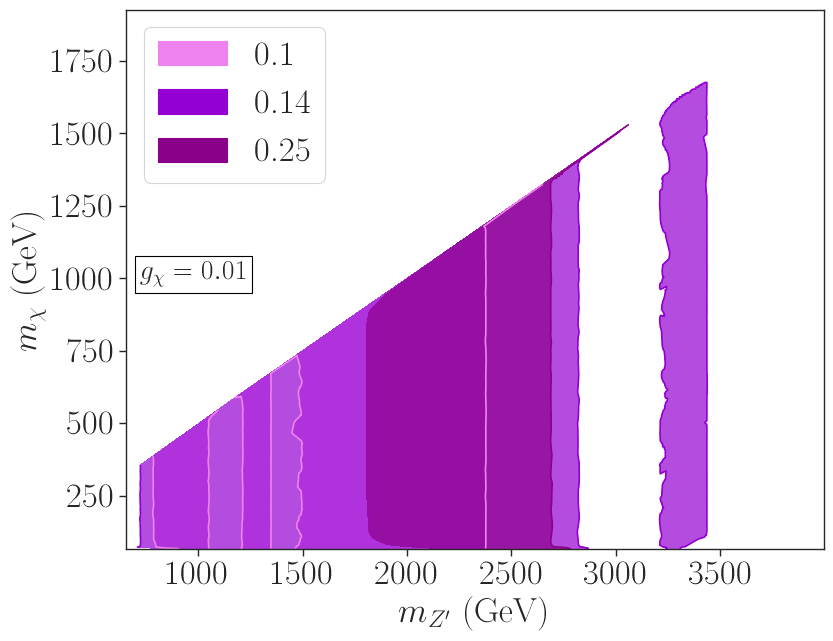

In [86]:
plt.figure(figsize=(9,7))

gqv_list = [0.1, 0.14, 0.25]
# gqv_list = [0.1]
gchi = 0.01
for gqv in gqv_list:          
    data = monojetData[(monojetData['extpar.1']==gchi)&(monojetData['extpar.2']==gqv)]
    rData = data['ExptRes.result0.r']
    if len(rData) == 0: continue
        
    pts = np.array([y for y in product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))])
    rPts = griddata(list(zip(data['mass.9900032'],data['mass.9000006'])),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    
    cs2 = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], colors=gqcolors[gqv])
    plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=.7, colors=gqcolors[gqv])    
#     plt.clabel(cs2, fontsize=12, fmt=str(gqv), inline=True, colors='black')
    cs2.collections[0].set_label(str(gqv))
    
plt.legend(handles=[gqLegend[0], gqLegend[1], gqLegend[2]], fontsize=25, loc='upper left')

plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
plt.text(0.02,0.5,r'$g_{\chi} = %1.2f$' % (gchi),fontsize=20,
         bbox=dict(facecolor='white', edgecolor='black'),transform = plt.gca().transAxes)

# plt.text(900,1330,r'$j = u, d, c, s, b$',fontsize=18)
# plt.savefig('exclusions_2mdm_all.png')
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.show()